## Population prior

In this notebook, we will study the BBH merger rate evolution with redshift. We approximate merger rate per comving volume at a given redshift $\mathcal{R}(z)$ as a Madau-Dickinson-like star formation rate profile,

$$ \mathcal{R}(z) = \Psi(z) \propto \frac{(1+z)^\alpha}{1 + \left (\frac{1+z}{1+c}\right)^{\alpha + \beta}}.$$

In other words, we are neglecting the time delay between star formation and merger. 
The merger rate distribution on redshift can then be written as

$$ p(z | \Lambda) \propto \frac{1}{1 + z} \frac{dV_c}{dz} \mathcal{R}(z),$$
where $dV_c /dz$ is the differential comoving volume and the $(1+z)^{-1}$ factor accounts for the translation between detector frame and source frame. Here, $\Lambda = \{\alpha, \beta, c, H_0, \Omega_m\}$ are cosmological and population parameters.

Using inversion sampling, wherein the CDF percentiles are sampled from a uniform distribution and inverted to yield an histogram over $z$. The function $p(z | \Lambda)$ will be normalized for an easier comparison with the histogram. For this exercise, we choose population parameters following the Madau-Dickinson curve: $(\alpha, \beta, c) = (2.7, 2.9, 1.9)$, $H_0 = 70 \, \text{km} \, \text{s}^{-1} \, \text{Mpc}^{-1}$ and $\Omega_m = 0.3$ with a flat $\Lambda\text{CDM}$ cosmology.

In [38]:
from dataclasses import dataclass
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from inference.utils import sample_from_func, EventGenerator
from inference.prior import UniformPrior
from inference.likelihood import DrawnGWMergerRatePriorInference

In [39]:
n = 1000
nevents = 50
nslice = 100
bins = 50
z = np.linspace(1e-4, 10., n)
# (2.7, 5.6 - 2.7, 2.9 - 1)
md_args = (2.7, 2.9, 1.9)
md_alpha, md_beta, md_c = md_args
fiducial_H0 = 70
H0_min, H0_max = 20, 140
alpha_min, alpha_max = -10, 10
beta_min, beta_max = 0., 10
c_min, c_max = 0., 4.
sigma_dl = 0.1
prior = UniformPrior(prior_min=np.array([H0_min, alpha_min, beta_min, c_min]), prior_max=np.array([H0_max, alpha_max, beta_max, c_max]))
inference = DrawnGWMergerRatePriorInference(
        z,
        prior,
        fiducial_H0=fiducial_H0,
        sigma_dl=sigma_dl,
        low_redshift=False,
    )
cosmology = inference.fiducial_cosmology
samples = sample_from_func(1000 * nevents, inference.p_cbc, z, md_args)

In [40]:
@dataclass
class SFR:
    alpha : float = md_alpha
    beta : float = md_beta
    c : float = md_c

    def __call__(self):
        return (self.alpha, self.beta, self.c)

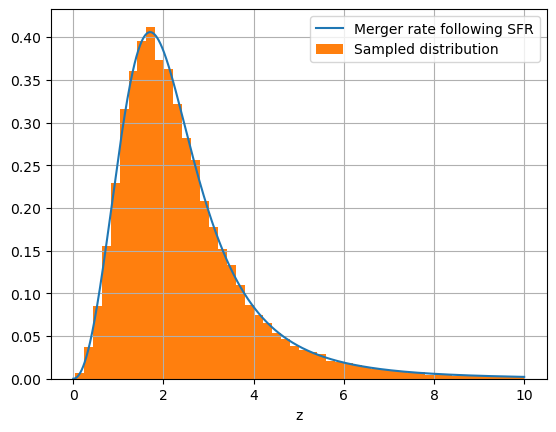

In [41]:
plt.plot(z, inference.p_cbc(z, md_args), label='Merger rate following SFR')
plt.hist(samples, bins=bins, density=True, label="Sampled distribution")
plt.xlabel('z')
plt.legend()
plt.grid()
plt.show()

The full posterior distribution for $\Lambda$ using the aforementioned redshift prior is given by 

$$ p(\Lambda) \propto \pi (\Lambda) \xi(\Lambda)^{-N_\text{det}}\prod_{i=1}^{N_\text{det}} \int \mathcal{L}(\hat{d}_L | d_L(z, H_0))p(z|\Lambda)dz,$$

with $p(z | \Lambda)$ defined above. $\mathcal{L}(\hat{d}_L | d_L(z, H_0))$ represents the single-event likelihood on the GW luminosity distance, and $\xi(\Lambda) = N_\text{det} / N_\text{obs}$ encodes the correction for selection effects due to Malmquist bias. We adopt flat priors $\pi(\Lambda)$ on all parameters, while leaving $\Omega_m$ fixed to 0.3.

The corresponding likelihood is implemented in the `DrawnGWMergerRatePriorInference` class. Let us plot some contours as a sanity check:

50 events were generated


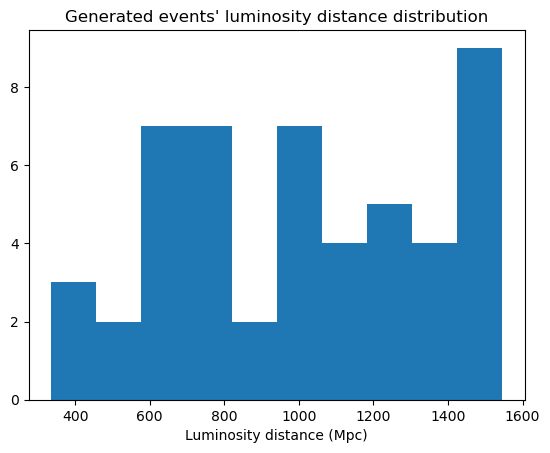

In [42]:
events = EventGenerator(fiducial_H0).from_redshifts(cosmology, samples, sigma_dl)[:nevents]
print(f"{len(events)} events were generated")
plt.hist(events)
plt.title("Generated events' luminosity distance distribution")
plt.xlabel('Luminosity distance (Mpc)')
plt.show()

## Visualizing the likelihood function

In the following cells, we plot slices of the likelihood function plotted over a single parameter at a time, while the others are left fixed.

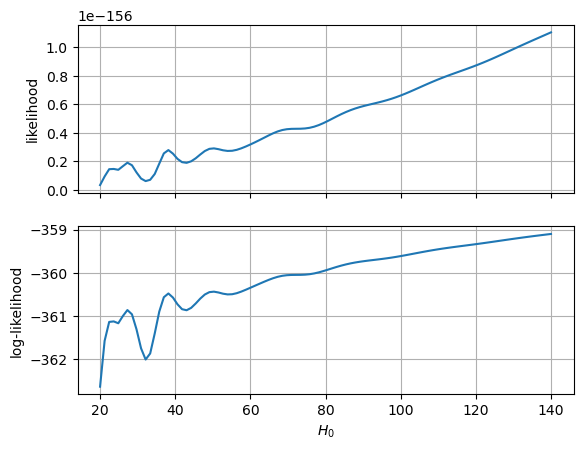

In [43]:
fig, ax = plt.subplots(2, 1, sharex=True)
H0_array = np.linspace(H0_min, H0_max, nslice)
loglike = [inference.log_likelihood((H0, *md_args), events, z) for H0 in H0_array]
like = [inference.likelihood((H0, *md_args), events, z) for H0 in H0_array]
ax[0].plot(H0_array, like)
ax[1].plot(H0_array, loglike)
plt.xlabel(r'$H_0$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')

ax[0].grid()
ax[1].grid()
plt.show()

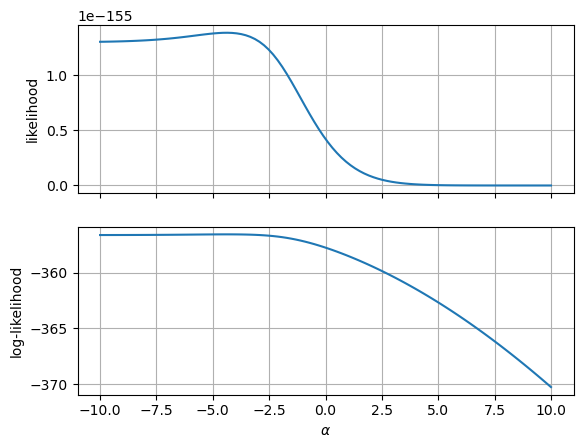

In [44]:
fig, ax = plt.subplots(2, 1, sharex=True)
alpha_array = np.linspace(alpha_min, alpha_max, nslice)
loglike = [inference.log_likelihood((fiducial_H0, *SFR(alpha=alpha)()), events, z) for alpha in alpha_array]
like = [inference.likelihood((fiducial_H0, *SFR(alpha=alpha)()), events, z) for alpha in alpha_array]
ax[0].plot(alpha_array, like)
ax[1].plot(alpha_array, loglike)
plt.xlabel(r'$\alpha$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')
ax[0].grid()
ax[1].grid()
plt.show()

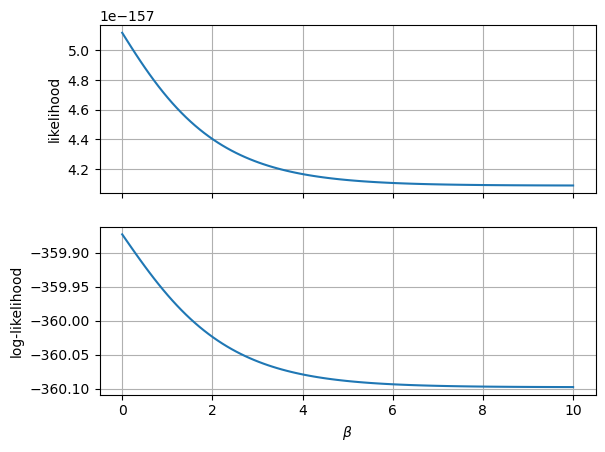

In [45]:
fig, ax = plt.subplots(2, 1, sharex=True)
beta_array = np.linspace(beta_min, beta_max, nslice)
loglike = [inference.log_likelihood((fiducial_H0, *SFR(beta=beta)()), events, z) for beta in beta_array]
like = [inference.likelihood((fiducial_H0, *SFR(beta=beta)()), events, z) for beta in beta_array]
ax[0].plot(beta_array, like)
ax[1].plot(beta_array, loglike)
plt.xlabel(r'$\beta$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')
ax[0].grid()
ax[1].grid()
plt.show()

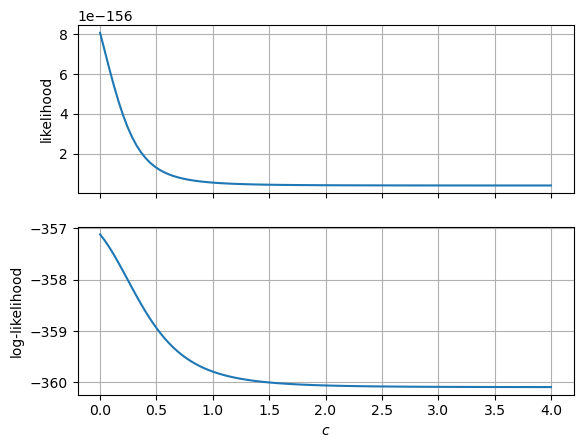

In [46]:
fig, ax = plt.subplots(2, 1, sharex=True)
c_array = np.linspace(c_min, c_max, nslice)
loglike = [inference.log_likelihood((fiducial_H0, *SFR(c=c)()), events, z) for c in c_array]
like = [inference.likelihood((fiducial_H0, *SFR(c=c)()), events, z) for c in c_array]
ax[0].plot(c_array, like)
ax[1].plot(c_array, loglike)
plt.xlabel(r'$c$')
ax[0].set_ylabel('likelihood')
ax[1].set_ylabel('log-likelihood')
ax[0].grid()
ax[1].grid()
plt.show()